# Extracting features and ready to train data

In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import random
import json
import collections
from PIL import Image
import pickle

In [ ]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 326s 0us/step


In [ ]:
with open('/content/annotations/captions_train2014.json', 'r') as f:
    annotations = json.load(f)

In [ ]:
# Group all captions together having the same image ID.
PATH='/content/train2014/'
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [ ]:

image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
image_paths=image_paths[:30000]

# Don't run this

In [ ]:
# storing the image path


with open('image_paths', 'wb') as fp:
    pickle.dump(image_paths, fp)

In [ ]:
with open ('image_paths', 'rb') as fp:
    img_pths = pickle.load(fp)

In [ ]:
for i in range(5):
  a=random.randint(0,20000)
  assert img_pths[a]==image_paths[a], 'something went wrong'
  print('correct!!')

correct!!
correct!!
correct!!
correct!!
correct!!


# Inception model for feature Extraction

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output


inception_feature_extraction=tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 0s 0us/step


# Saving the feature in trainable format

In [ ]:
def fe(img):
  i=tf.io.read_file(img)
  i=tf.image.decode_jpeg(i, channels=3)
  i=tf.image.resize(i, (299, 299))
  i=tf.keras.applications.inception_v3.preprocess_input(i)
  i=tf.expand_dims(i,0)
  i=inception_feature_extraction(i)
  i=tf.reshape(i,(64,2048))
  return i.numpy()

In [ ]:
# Feature extraction from pretrained Inception model

#train_features=[]
k=0
for i in image_paths:
  k=k+1
  np.save(i,fe(i))
  #train_features.append(fe(i))
  if k%500 ==0:
    print(k)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000


In [ ]:
train_captions = []
img_pths=[]
for i in range(len(image_paths)):
  caption_list = image_path_to_caption[image_paths[i]]
  train_captions.extend(caption_list)
  img_pths.extend([image_paths[i]] * len(caption_list))

In [ ]:
len(img_pths)

150059

In [ ]:
# Checking if inception extraction is convertible to tflite

path='/content/drive/MyDrive/models/Image_captioning app/2'
tf.saved_model.save(inception_feature_extraction,path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/2/assets


In [ ]:
converter=tf.lite.TFLiteConverter.from_saved_model(path)

In [ ]:
imported = tf.saved_model.load(path)
print(imported.signatures)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_1) at 0x7F2788C17550>})


# Caption Preprocess

In [ ]:
# Tokenizing text
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=5000, 
                                                    oov_token='<oov>',
                                                    filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)


Checking the oov distribution


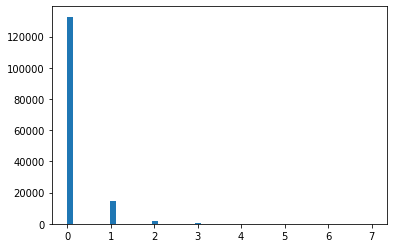

In [ ]:
# Lets see <oov> distribution 
cap=tokenizer.texts_to_sequences(train_captions)

print('Checking the oov distribution')

h=[i.count(1) for i in cap]
plt.hist(h ,bins=50)
plt.show()

We can see that very few sentences has oov token more than 1

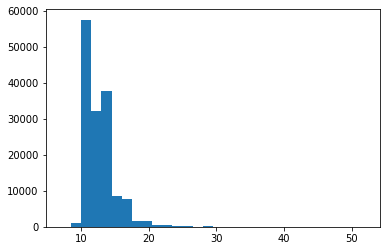

In [ ]:
# Length distribution
l=[len(i) for i in cap]
plt.hist(l ,bins=30)
plt.show()


In [ ]:
# lets pad this upto len 22

cpt=tf.keras.preprocessing.sequence.pad_sequences(
    cap, maxlen=23, padding='post', truncating='post')


# add pad token to dict
tokenizer.word_index['<pad>']=0
print('shape of final processed captions :',cpt.shape)
wd_itow={i:j for j,i in tokenizer.word_index.items()}

print('<start> and <end> token no are {} and {} resp'.format(tokenizer.word_index['<start>'],tokenizer.word_index['<end>']))

shape of final processed captions : (150059, 23)
<start> and <end> token no are 3 and 4 resp


In [ ]:
import json

with open('/content/drive/MyDrive/models/Image_captioning app/dict.json','w') as f:
  json.dump(d,f,indent=2)

In [ ]:
cpt.shape

(150059, 23)

# Data Loading

In [ ]:
def mapfn(x,y):
  img_tns=np.load(x.decode('utf-8')+'.npy')
  return img_tns,y

In [ ]:

trn=tf.data.Dataset.from_tensor_slices((img_pths,cpt))
trn = trn.map(lambda item1, item2: tf.numpy_function(
          mapfn, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
trn=trn.shuffle(1000,reshuffle_each_iteration=True).batch(64,drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

In [ ]:
# Encoder

class CNN_Encoder(tf.keras.Model):
  def __init__(self):
    super(CNN_Encoder,self).__init__()
    #self.fc1=tf.keras.layers.Dense(512)
    self.fc = tf.keras.layers.Dense(256,activation='relu')

  def call(self,inputs):
    #out=self.fc1(inputs)
    out=self.fc(inputs)
    return out

enc=CNN_Encoder()

In [ ]:
# Checking the correctness of encoder
inp=trn_ftr[0].reshape((1,64,2048))
out=enc(inp)

assert out.shape==(1,64,256),'Something went wrong'
print('looks fine!!')

looks fine!!


In [ ]:
enc.summary()

Model: "cnn__encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  524544    
Total params: 524,544
Trainable params: 524,544
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.saved_model.save(enc,path)
converter=tf.lite.TFLiteConverter.from_saved_model(path)
imported = tf.saved_model.load(path)
print(imported.signatures)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/2/assets
_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_1) at 0x7F2782116710>})


In [ ]:
# Word Alignment

class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.w1=tf.keras.layers.Dense(units)
    self.w2=tf.keras.layers.Dense(units)
    self.v=tf.keras.layers.Dense(1)
    self.activation = tf.keras.layers.Activation('tanh')

  def call (self,inputs):
    dec_hid,enc_out=inputs
    x=self.w1(dec_hid)+self.w2(enc_out)
    x=self.activation(x)
    x=self.v(x)
    wghts=tf.keras.activations.softmax(x,axis=1)
    context_vector=wghts*enc_out
    context_vector=tf.reduce_sum(context_vector,axis=1)
    return wghts,context_vector

at=BahdanauAttention(256)

In [ ]:
#Testing the attention layer

dec_hid = tf.zeros((1,1,256))

inputs=[dec_hid,out]
weights,context_vector=at(inputs)
assert weights.shape==(1,64,1), 'Somthing went wrong with weights'
assert context_vector.shape==(1,256), 'Somthing went wrong with context_vector'
print('looks fine')

# Printing the weights
weights

looks fine


<tf.Tensor: shape=(1, 64, 1), dtype=float32, numpy=
array([[[0.01052245],
        [0.01249215],
        [0.01772313],
        [0.02253019],
        [0.0234569 ],
        [0.0197035 ],
        [0.01545711],
        [0.0084044 ],
        [0.0128596 ],
        [0.01129285],
        [0.01266724],
        [0.01451955],
        [0.01194725],
        [0.0129849 ],
        [0.00787702],
        [0.00682098],
        [0.01326701],
        [0.00897275],
        [0.00641177],
        [0.01184812],
        [0.01088392],
        [0.01253196],
        [0.00858605],
        [0.01785402],
        [0.02022077],
        [0.02018351],
        [0.01994715],
        [0.02016301],
        [0.01278407],
        [0.00916066],
        [0.00751155],
        [0.01776459],
        [0.01824783],
        [0.01809319],
        [0.03209174],
        [0.03004121],
        [0.0203446 ],
        [0.00704611],
        [0.00666097],
        [0.02177604],
        [0.01590361],
        [0.01630157],
        [0.02227497],
  

In [ ]:
at.summary()

Model: "bahdanau_attention"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  65792     
_________________________________________________________________
dense_2 (Dense)              multiple                  65792     
_________________________________________________________________
dense_3 (Dense)              multiple                  257       
_________________________________________________________________
activation_94 (Activation)   multiple                  0         
Total params: 131,841
Trainable params: 131,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.saved_model.save(at,path)
converter=tf.lite.TFLiteConverter.from_saved_model(path)
imported = tf.saved_model.load(path)
print(imported.signatures)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/2/assets
_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_1, input_2) at 0x7F277F1BB4E0>})


In [ ]:
# Decoder
class Decoder(tf.keras.Model):
  def __init__(self):
    super(Decoder,self).__init__()
    self.em=tf.keras.layers.Embedding(5001,512)
    self.dec=tf.keras.layers.GRU(256,activation='relu',return_state=True,return_sequences=True)
    self.dense=tf.keras.layers.Dense(5001)
    self.attention=BahdanauAttention(256)
    #self.dense1=tf.keras.layers.Dense(512)

  def call(self,inputs):
    enc_out,dec_hidden,inp=inputs
    x=self.em(inp)
    weights,context_vector=self.attention([dec_hidden,enc_out])
    context_vector=tf.expand_dims(context_vector, 1)
    concat=tf.keras.layers.concatenate([x,context_vector,dec_hidden],axis=2)
    dec_out,dec_hidden=self.dec(concat)
    #x=self.dense1(dec_out)
    pred=self.dense(dec_out)
    return dec_hidden,pred,weights
  
  
dec=Decoder()

In [ ]:
# Testing Decoder

inp=np.array([3]).reshape((1,1))
input=[out,dec_hid,inp]
dec_hidden,pred,weights=dec(input)

assert weights.shape==(1,64,1), 'Somthing went wrong with weights'
assert dec_hidden.shape==(1,256), 'Somthing went wrong with decoder hidden'
assert pred.shape==(1,1,5001), 'Somthing went wrong with prediction vector'

print('looks good')

looks good


In [ ]:
dec.summary()

Model: "decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  2560512   
_________________________________________________________________
gru_2 (GRU)                  multiple                  984576    
_________________________________________________________________
dense_14 (Dense)             multiple                  1285257   
_________________________________________________________________
bahdanau_attention_3 (Bahdan multiple                  131841    
Total params: 4,962,186
Trainable params: 4,962,186
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.saved_model.save(dec,path)
converter=tf.lite.TFLiteConverter.from_saved_model(path)
imported = tf.saved_model.load(path)
print(imported.signatures)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/2/assets


_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_1, input_2, input_3) at 0x7F278DAA80B8>})


In [ ]:
# Creating required APIs
ls_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()
acc=tf.keras.metrics.Accuracy()

In [ ]:
# with autograph

class Test_step():
  def __init__(self,batch):
    self.batch=batch
    self.pred_out=[]
    self.loss=0

  @tf.function
  def  __call__(self,inp,out):
    with tf.GradientTape() as tape:
      enc_out=enc(inp)
      dec_hid=tf.zeros(shape=(self.batch,1,256))
      for i in range(1,out.shape[1]):
        dec_inp=tf.reshape(out[:,i-1],shape=(self.batch,1))
        dec_hid,pred,weights=dec([enc_out,dec_hid,dec_inp])
        dec_hid=tf.reshape(dec_hid,shape=(self.batch,1,dec_hid.shape[-1]))
        self.pred_out.append(pred)

      ypred=tf.concat(self.pred_out,axis=1)

      ls=ls_(out[:,1:],ypred)

    variables = enc.trainable_variables + dec.trainable_variables
    gradients = tape.gradient(ls, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    #self.dec_hidden=dec_hid
    return ls,ypred

In [ ]:
# Lets train the model for 20 epochs
# Training...
batch=64
#step=Test_step(batch)
#trn=trn.shuffle(1000).batch(batch,drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
#trn=tf.data.Dataset.from_tensor_slices((trn,hn)).batch(batch,drop_remainder=True).shuffle(80000, reshuffle_each_iteration=True)
epochs=6
print('Training starts ...')
for j in range(epochs):
  t=time.time()
  print('\n\n---Epoch {}  :----'.format(j+1))
  for i,(inp,out) in enumerate(trn):
    ls,ypred=step(inp,out)
    ypred=tf.math.argmax(ypred,axis=2)
    ypred=tf.reshape(ypred,shape=out[:,1:].shape)
    ac=acc(ypred,out[:,1:])
    if (i+1)%200==0:
      print('At {}th batch    loss={} , accuracy={}'.format(i+1,ls,ac))

  t=time.time()-t
  print('\nTime required for {}th epoch : {}'.format(j+1,t))

Training starts ...


---Epoch 1  :----
At 200th batch    loss=1.0193533897399902 , accuracy=0.7386730909347534
At 400th batch    loss=0.8717350363731384 , accuracy=0.7388383746147156
At 600th batch    loss=0.9103328585624695 , accuracy=0.7390006184577942
At 800th batch    loss=0.9322250485420227 , accuracy=0.7391602396965027
At 1000th batch    loss=0.9093019962310791 , accuracy=0.7393214106559753
At 1200th batch    loss=1.12517249584198 , accuracy=0.7394710779190063
At 1400th batch    loss=1.0463237762451172 , accuracy=0.7396174669265747
At 1600th batch    loss=0.9422875046730042 , accuracy=0.7397670149803162
At 1800th batch    loss=0.9286426305770874 , accuracy=0.7399148344993591
At 2000th batch    loss=0.9277843236923218 , accuracy=0.7400665879249573
At 2200th batch    loss=0.9376111626625061 , accuracy=0.7402229905128479

Time required for 1th epoch : 439.3854115009308


---Epoch 2  :----
At 200th batch    loss=1.0289009809494019 , accuracy=0.740492045879364
At 400th batch    loss=

In [ ]:
 ;

#Saving Model

In [ ]:
#reference
#class Model(tf.keras.Model):
  def __init__(self,enc,dec):
    super(Model,self).__init__()
    self.enc=enc
    self.dec=dec

  @tf.function
  def  call (self,inp):
    result=[]
    enc_out,dec_hid=self.enc(inp)
    dec_inp=tf.reshape(inp[:,0],shape=[1,1])
    for i in range(1,13):
      dec_hid=tf.reshape(dec_hid,shape=(1,1,dec_hid.shape[-1]))
      dec_hid,pred,weights=self.dec([enc_out,dec_hid,dec_inp])
      dec_inp=tf.reshape(tf.math.argmax(pred,axis=2),shape=(1,1))
      result.append(dec_inp)
    o=tf.concat(result,axis=1)
    o=tf.squeeze(o,axis=[0])
    return o

In [ ]:
class Model(tf.keras.Model):
  def __init__(self,enc,dec,inception_feature_extraction):
    super(Model,self).__init__()
    self.enc=enc
    self.dec=dec
    self.inception_feature_extraction=inception_feature_extraction
    #self.con=tf.constant([3],tf.int32,(1,1))

  @tf.function
  def call (self,inp):
    result=[]
    i=self.inception_feature_extraction(inp)
    i=tf.reshape(i,(1,64,2048))
    enc_out=self.enc(i)
    dec_hid=tf.zeros(shape=(1,1,256))
    #dec_inp=tf.constant(inp[:,0],shape=[1,1])
    dec_inp=tf.constant([3],tf.int32,(1,1))
    for i in range(1,23):
      dec_hid=tf.reshape(dec_hid,shape=(1,1,dec_hid.shape[-1]))
      dec_hid,pred,weights=self.dec([enc_out,dec_hid,dec_inp])
      dec_inp=tf.reshape(tf.math.argmax(pred,axis=2),shape=(1,1))
      result.append(dec_inp)
    o=tf.concat(result,axis=1)
    o=tf.squeeze(o,axis=[0])
    return o

In [ ]:
model=Model(enc,dec,inception_feature_extraction)

In [ ]:
inp=image_paths[10]
i=tf.io.read_file(inp)
i=tf.image.decode_jpeg(i, channels=3)
i=tf.image.resize(i, (299, 299))
i=tf.keras.applications.inception_v3.preprocess_input(i)
i=tf.expand_dims(i,0)
i=i.numpy()

In [ ]:
model(i)

<tf.Tensor: shape=(22,), dtype=int64, numpy=
array([  2, 285,   6, 110,  10,  22, 242,   8,   2, 628, 100,   4,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0])>

In [ ]:
path='/content/drive/MyDrive/models/Image_captioning app/1'

In [ ]:
tf.saved_model.save(
    model, path,
    signatures=model.call.get_concrete_function(
        tf.TensorSpec(shape=[1, 299, 299, 3], dtype=tf.float32, name="inp")))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/Image_captioning app/1/assets


In [ ]:
pip install tf-nightly

     |████████████████████████████████| 401.0MB 41kB/s 
     |████████████████████████████████| 4.0MB 57.0MB/s 
     |████████████████████████████████| 471kB 53.0MB/s 
     |████████████████████████████████| 12.2MB 255kB/s 
     |████████████████████████████████| 4.0MB 49.3MB/s 
ERROR: tensorflow 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0


In [ ]:
converter=tf.lite.TFLiteConverter.from_saved_model(path)
imported = tf.saved_model.load(path)
print(imported.signatures)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, inp) at 0x7F169C6224A8>})


In [ ]:
tflite_model = converter.convert()

In [ ]:
pa='/content/drive/MyDrive/models/Image_captioning app/model.tflite'

'/content/drive/MyDrive/models/Image_captioning app/1'

In [ ]:
with open('/content/drive/MyDrive/models/Image_captioning app/model.tflite','wb') as f:
  f.write(tflite_model)

In [ ]:
with open('/content/wd_itow') as f:
  d=json.load(f)

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [ ]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

In [ ]:
interpreter.invoke()

In [ ]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
type(d)

dict

In [ ]:
d['2']

'a'